In [3]:
import rioxarray
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [41]:
points = gpd.read_file("C:/Users/leoni/Documents/Uni/UGS/example_data/training_data.shp")
AOI = gpd.read_file("C:/Users/leoni/Documents/Uni/UGS/example_data/clip_area.shp")

crs_code = AOI.crs.to_string()

In [5]:
b2 = rioxarray.open_rasterio("example_data/T32UPU_20210814T102031_B02_10m_extent.tif").rio.reproject("EPSG:25832")
b3 = rioxarray.open_rasterio("example_data/T32UPU_20210814T102031_B03_10m_extent.tif").rio.reproject("EPSG:25832")
b4 = rioxarray.open_rasterio("example_data/T32UPU_20210814T102031_B04_10m_extent.tif").rio.reproject("EPSG:25832")
b8 = rioxarray.open_rasterio("example_data/T32UPU_20210814T102031_B08_10m_extent.tif").rio.reproject("EPSG:25832")

In [6]:
# Crop and mask the rasters
b2_clip = b2.rio.clip(AOI.geometry)
b3_clip = b3.rio.clip(AOI.geometry)
b4_clip = b4.rio.clip(AOI.geometry)
b8_clip = b8.rio.clip(AOI.geometry)

In [7]:
# Calculate NDVI and NDWI
ndvi = (b8_clip - b4_clip) / (b8_clip + b4_clip)
ndwi = (b3_clip - b8_clip) / (b3_clip + b8_clip)

In [14]:
ndvi_path = "path_ndvi.tif"
ndwi_path = "path_ndwi.tif"
ndvi.rio.to_raster(ndvi_path)
ndwi.rio.to_raster(ndwi_path)

In [15]:
from rasterstats import point_query

def extract_raster_values(raster_path, points, band=1):
    # Extract values
    values = point_query(points, raster_path, band=band)
    return pd.DataFrame({raster_path: values})

b2_path = "example_data/T32UPU_20210814T102031_B02_10m_extent.tif"
b3_path = "example_data/T32UPU_20210814T102031_B03_10m_extent.tif"
b4_path = "example_data/T32UPU_20210814T102031_B04_10m_extent.tif"
b8_path = "example_data/T32UPU_20210814T102031_B08_10m_extent.tif"

b2_values = extract_raster_values(b2_path, points)
b3_values = extract_raster_values(b3_path, points)
b4_values = extract_raster_values(b4_path, points)
b8_values = extract_raster_values(b8_path, points)

ndvi_path = "path_ndvi.tif"
ndwi_path = "path_ndwi.tif"
ndvi_values = extract_raster_values(ndvi_path, points)
ndwi_values = extract_raster_values(ndwi_path, points)

extracted_values = pd.concat([b2_values, b3_values, b4_values, b8_values, ndvi_values, ndwi_values], axis=1)

C:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


<Axes: >

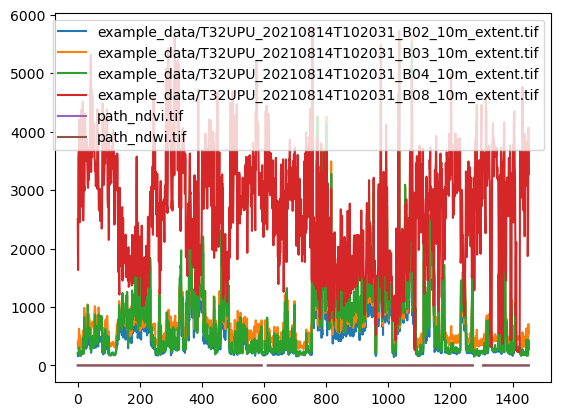

In [17]:
extracted_values.plot()

In [39]:
extracted_values

,b2,b3,b4,b8,ndvi,ndwi,class
0,197.024507,396.696159,215.753135,2503.357655,0.842053,-0.726041,1
1,156.983526,281.737592,223.518066,1632.427338,0.745514,-0.697579,1
2,200.265477,437.329221,202.131516,3568.373923,0.892665,-0.780789,1
3,186.211496,440.454569,204.129375,3655.807181,0.893846,-0.783538,1
4,233.493112,628.315270,303.826116,3728.948089,0.849108,-0.711401,1
...,...,...,...,...,...,...,...
1448,192.599560,382.287290,192.193491,3706.531867,0.901151,-0.812492,1
1449,215.864610,339.101470,207.218052,1871.859162,0.800661,-0.693118,1
1450,186.678479,298.462384,170.147678,2387.350029,0.865956,-0.776620,1
1451,346.817654,708.258162,438.575460,4068.885569,0.804126,-0.702526,0


In [24]:
df = extracted_values

df.columns = ["b2", "b3", "b4", "b8", "ndvi", "ndwi"]

df['class'] = points['class']

df.fillna(0, inplace=True)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), df['class'], test_size=0.2, random_state=123)

In [26]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
predictions = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, predictions)

In [31]:
conf_matrix

array([[154,  12],
       [ 12, 102]], dtype=int64)

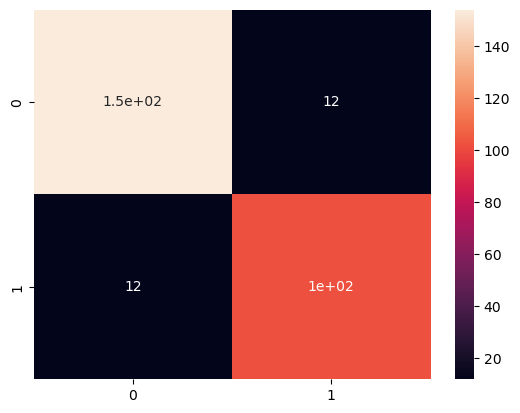

In [28]:
sns.heatmap(conf_matrix, annot=True)
plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, predictions))

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       166
           1       0.89      0.89      0.89       114

    accuracy                           0.91       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.91      0.91      0.91       280

Accuracy: 0.91


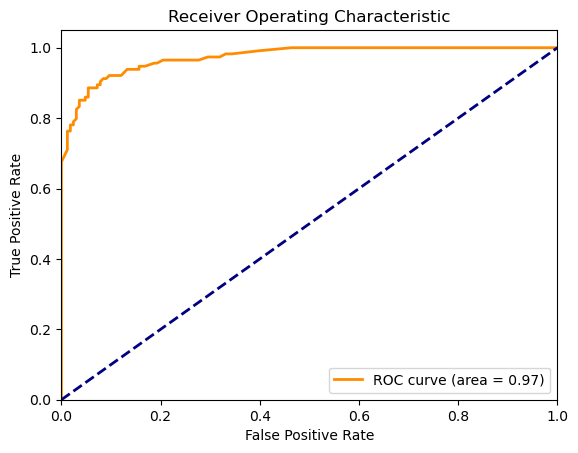

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

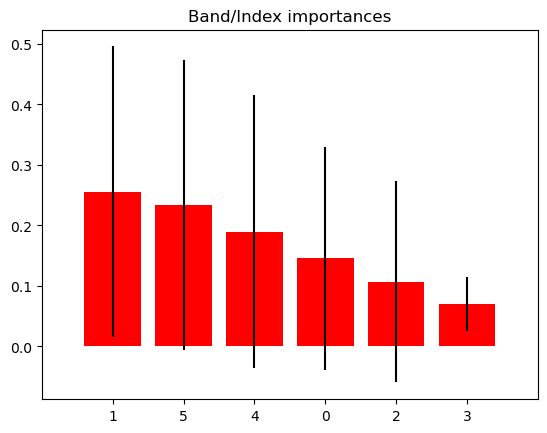

In [45]:
# Feature importances
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Band/Index importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [42]:
print(points['class'].unique())
print(points['class'].value_counts())

[1 0]
class
0    827
1    626
Name: count, dtype: int64


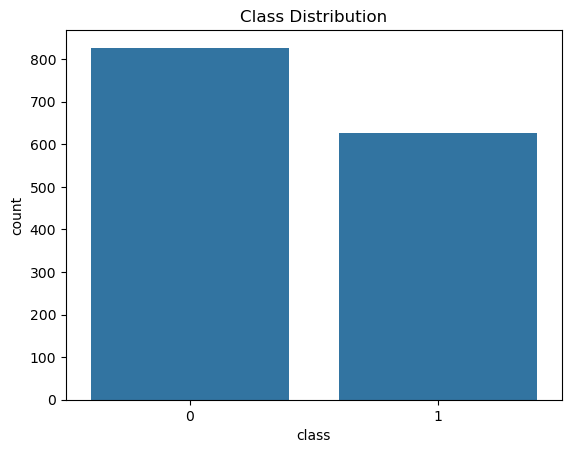

In [44]:
sns.countplot(x='class', data=points)
plt.title('Class Distribution')
plt.show()